# Mini-Projet : Segmentation d'images TEP par classification spectrale

L'objectif de ce TP est de segmenter des images de Tomographie par Emission de Positons (TEP) via des méthodes de classification non supervisée et, en particulier, une méthode de classification spectrale.

## Principe de l'imagerie TEP

La Tomographie par Emission de Positons (ou TEP) est une technique d'imagerie médicale fonctionnelle quantitative permettant de visualiser les activités du métabolisme. Les données TEP forment une sèquence _3D + t_ qui traduit l'évolution de la radioactivité dans le temps du volume correspondant au champ de vue de l'appareil de mesure.

<img src="files/PrincipePET.png" width="600" height="300">

Nous nous intéressons, dans ce TP, à la segmentation d'une coupe transverse et sagittale du cerveau, réprésentée respectivement à gauche et à droite sur la figure ci-dessous. Le nombre de classes à retrouver correspond aux différentes couleurs représentées sur la figure. Ici, l'information géométrique (position de chaque pixel dans l'image) n'est pas prise en compte.

<img src="files/zubal_fig3.png" width="600" height="300">

Ce mini-projet se décompose en 5 parties:

- **Partie I :** implémentation de la classification spectrale avec exemple jouet
- **Partie II :** application de la classification spectrale sur les protils temporels TACs
- **Partie III :** classification par Kmeans puis par réduction de dimension ACP+Kmeans
- **Partie IV :** évaluation des résultats
- **Partie V :** votre analyse


In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


## Partie I : Classification spectrale

Parmi les méthodes de partitionnement non supervisé, les méthodes à noyaux reposent sur le même principe : elles utilisent des relations d'adjacence (d'affinité) entre tous les couples de points sans a priori sur les formes des classes. Nous nous concentrons sur l'algorithme de classification spectrale décrit ci-dessous, très simple à implémenter. La mesure d'affinité utilisée est l'affinité gaussienne qui dépend d'un paramètre noté $\sigma$.

On dispose d'un ensemble de données $S=\{x_i\}_{i=1,..,n}\in \mathbb{R}^p$ composé de $n$ points de dimension $p$ et d'un nombre de classes, noté $k$, à obtenir. La méthode de classification spectrale consiste à extraire les vecteurs propres associés aux plus grandes valeurs propres d'une matrice d'affinité normalisée. Ces vecteurs propres constituent ensuite un espace de dimension réduite dans lequel les données transformées seront linéairement séparables.

<img src="files/AlgoSC.png" width="600" height="300">
<img src="files/SCexple.png" width="600" height="300">

### Travail demandé

- Ecrire la fonction **classification_spectrale** implantant l'algorithme 1. Cette fonction en entrée les données Input de l'algorithme.
- Tester la fonction sur le jeu de données _ToyExample.mat_ et tester différentes valeurs de paramètres $\sigma$. Les résultats sont-ils similaires ?

### Fonctions python utiles

- exp (numpy)
- norm (linalg)
- inv (linalg)
- eig (linalg)
- KMeans (sklearn)


In [3]:
def norms1(x: np.ndarray) -> np.ndarray:
    d = np.zeros(x.shape)
    for i in range(x.shape[0]):
        s = 0
        for j in range(x.shape[0]):
            s += x[i, j]
        d[i, i] = s
    return d

def norms2(x: np.ndarray) -> np.ndarray:
    y = np.zeros(x.shape)
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            y[i, j] = x[i, j] / np.sqrt(np.sum(x[i]**2))
    return y

def classification_spectrale(Data, k: int, sigma: float):
    Data = np.asarray(Data)
    k = int(k)
    # construction de la matrice affinité
    size = np.shape(Data)[0]
    A = np.zeros((size, size))
    for i in range(size):
        for j in range(size):
            if (i != j):
                val = np.exp(-(np.linalg.norm(Data[i] -
                             Data[j]))**2/(2*sigma**2))
                A[i][j] = val
            else:
                val = 0
                A[i][i] = val

    # Normalisation de la matrice affinité
    D = norms1(A)
    L = np.linalg.inv(D).dot(A)

    # Calcul des vecteurs propres de L
    val_p, vec_p = np.linalg.eig(L)

    # Extraction des k + grands vecteurs propres
    X = []
    w_arg = np.argsort(val_p)
    w_arg = np.flip(w_arg)
    for i in range(k):
        X.append(vec_p[:, w_arg[i]])
    X = np.array(X)

    # Normalisation des lignes de X
    Y = norms2(X)

    # Kmeans sur l'espace spectral
    PartitionSC = np.zeros((size, 1))
    kmean: KMeans = KMeans(
        n_clusters=k
    )
    PartitionSC = kmean.fit(Y.T)
    return PartitionSC.labels_


### Application : toy example


Text(0.5, 1.0, 'Visualisation classification spectrale')

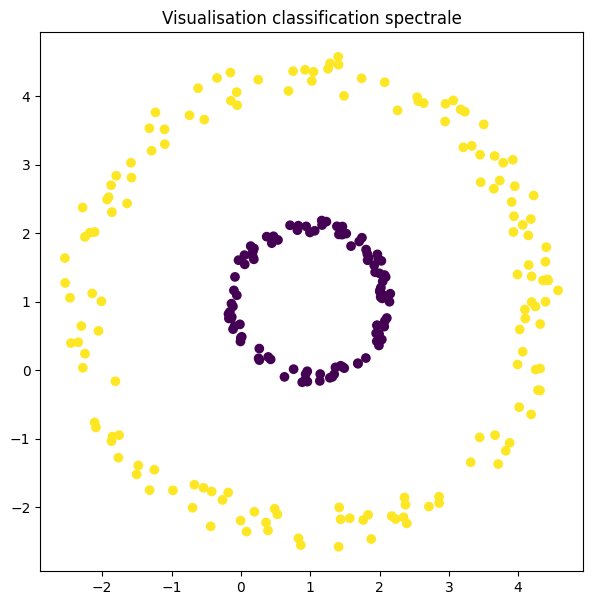

In [6]:
matJouet = scipy.io.loadmat('ToyExample.mat')

ExpleJouet = pd.DataFrame(matJouet['Data'])
ExpleJouet = np.asarray(ExpleJouet)

# Visualisation du jeu de données
# plt.plot(ExpleJouet[:, 0], ExpleJouet[:, 1], '.')

# Classification du jeu de données
class_jeu = classification_spectrale(ExpleJouet, 2, 0.1)

# Visualisation des classes

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(7, 7))
axs.scatter(ExpleJouet[:, 0], ExpleJouet[:, 1], c=class_jeu)
axs.set_title('Visualisation classification spectrale')


# Partie II : application de la classification spectrale sur les protils temporels TACs

La segmentation des images TEP repose donc sur une classification de profils temporels très bruités sans disposer de connaissance a priori. Ces profils temporels s'appellent des courbes Temps-Activité (notées TAC pour _Time Activity Curves_). Comme ils traduisent l'évolution de la radioactivité, elles comportent principalement 2 phases : une phase de croissance suivie d'une phase de décroissance. Suivant les tissus, les profils temporels vont présenter différentes amplitudes et des phases de croissance et de décroissance de durées plus ou moins longues.

La simulation numérique est couramment utilisée dans le domaine du traitement d'image. Elle
constitue une aide précieuse pour le développement et l'évaluation de méthodes car elle permet de
disposer d'une vérité terrain à laquelle on va comparer les résultats obtenus. Un exemple de simulation de TACs est représenté sur la figure suivante

Dans l'imagerie médicale, ces simulations sont généralement effectuées selon la méthode Monte-Carlo, particulièrement adaptées à la physique nucléaire à
cause de la nature stochastique des processus d'émission, de transport et de détection.

<img src="files/TAC_simu_reel.png" width="800" height="400">

On dispose de données temporelles simulées (séquences de 20 instants) d'une coupe transverse et d'une coupe sagittale de taille $64\times 54$ (représentées sur la figure ci-dessus) que l'on souhaite segmenter sans prendre en compte l'information géométrique. On dispose aussi de la vérité terrain c'est-à-dire de la segmentation de ces coupes avant simulation. Ces matrices sont stockées respectivement dans les fichiers _DataTAC_S.mat_ et _DataTAC_T.mat_.


Nombre de TAC de la coupe Sagittale : (3456, 20)
Nombre de TAC de la coupe Sagittale : (3456, 20)


Text(0.5, 1.0, 'TAC de Coupe Transverse')

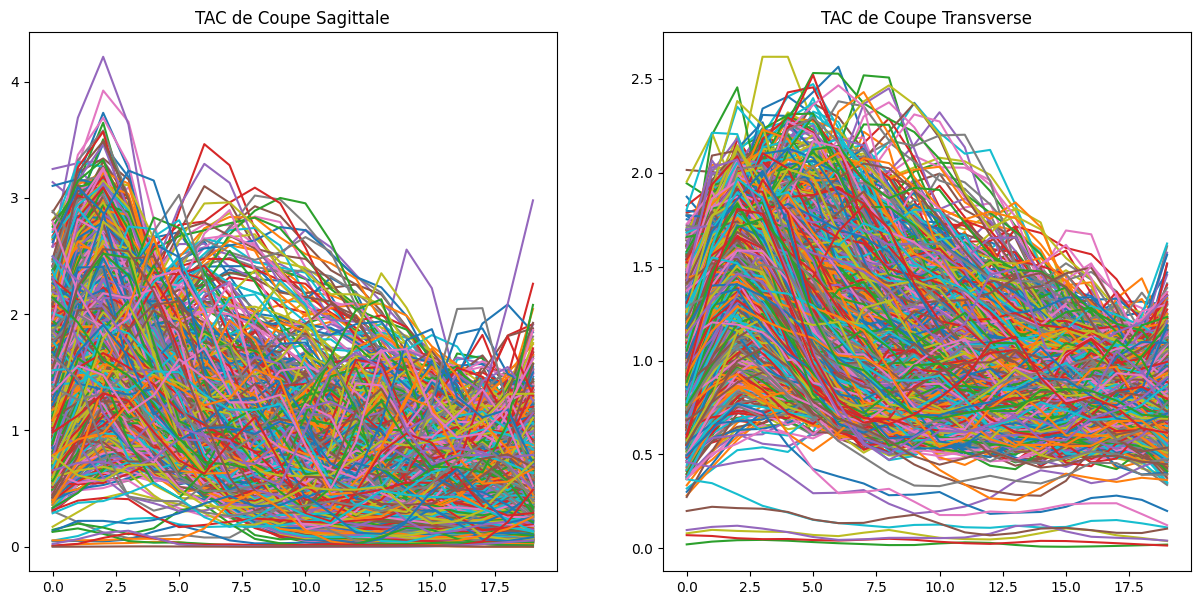

In [8]:
# Chargement de la coupe sagittale
matS = scipy.io.loadmat('DataTAC_S.mat')
data_S = pd.DataFrame(matS['DataTAC_S'])

print('Nombre de TAC de la coupe Sagittale :' ,data_S.shape)

# Chargement de la coupe transverse
matT = scipy.io.loadmat('DataTAC_T.mat')
data_T = pd.DataFrame(matT['DataTAC_T'])

print('Nombre de TAC de la coupe Sagittale :', data_T.shape)

# Affichage des TAC des deux coupes
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
axs[0].plot(data_S.T)
axs[0].set_title('TAC de Coupe Sagittale')
axs[1].plot(data_T.T)
axs[1].set_title('TAC de Coupe Transverse')


Classification spectrale sur image sagittale


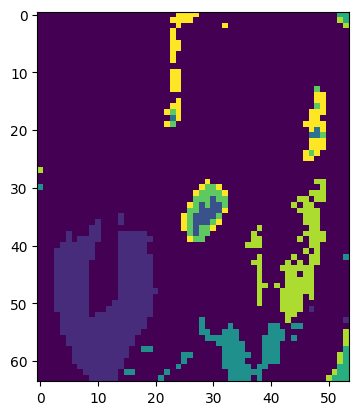

In [11]:
# Test de la classification spectrale sur image sagittale de taille (54,64) comprenant 9 classes
# PartitionSC_S = np.zeros((3456))
print("Classification spectrale sur image sagittale")
PartitionSC_S = classification_spectrale(data_S, 9, 0.35)

# Redimensionnement de la partition de la coupe saggitale en (54,64)
ImSagittaleSC=np.reshape(PartitionSC_S,((54,64)))
plt.imshow(ImSagittaleSC.T)

Classification spectrale sur image transverse


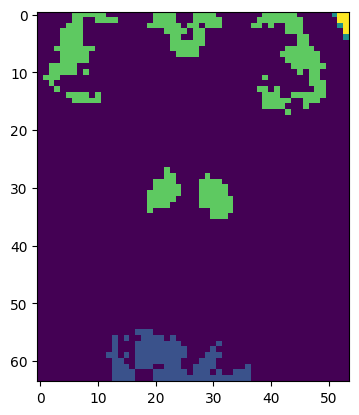

In [12]:
# Test de la classification spectrale sur image sagittale de taille (54,64) comprenant 5 classes

# PartitionSC_T=np.zeros((3456))
print("Classification spectrale sur image transverse")
PartitionSC_T = classification_spectrale(data_T, 5, 0.35)

# Redimensionnement de la partition de la coupe saggitale
ImTransverseSC=np.reshape(PartitionSC_T,(54,64))

plt.imshow(ImTransverseSC.T)


# Partie III : comparaison avec kmeans (+ ACP)

- Réaliser une classification avec le kmeans de sklearn
- Tester aussi une réduction de dimension par ACP comme étape de prétraitement qui conserverait 95% de l'information


Text(0.5, 1.0, 'Kmeans')

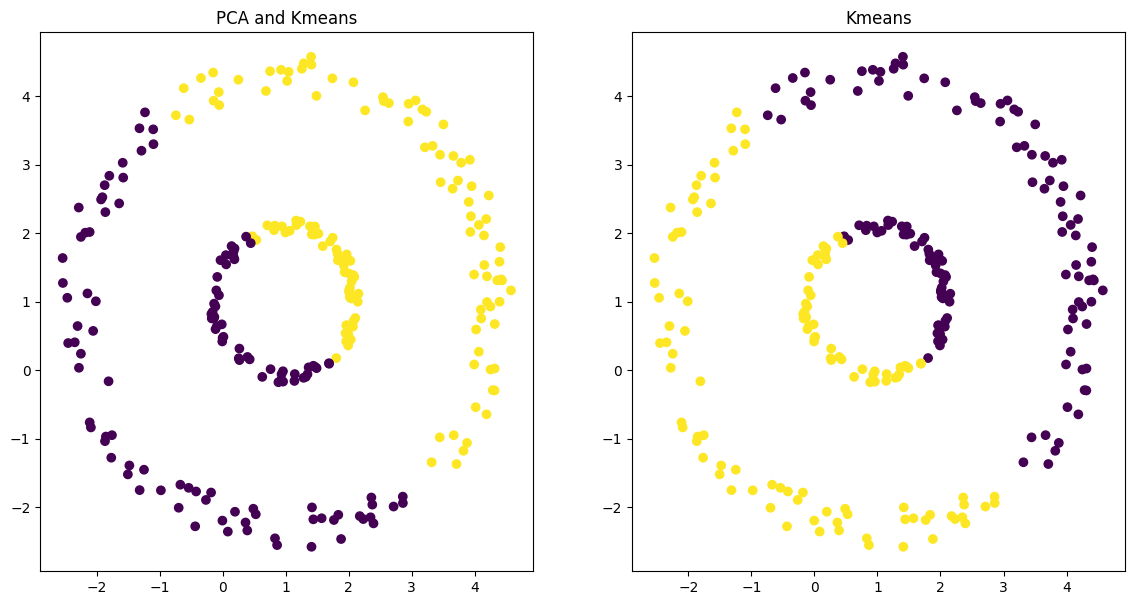

In [17]:
# Tester Kmeans avec l'exemple jouet et afficher le résultat
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

kmean: KMeans = KMeans(n_clusters=2)
pca: PCA = PCA(2)
data = pca.fit_transform(ExpleJouet)
labels = kmean.fit_predict(data)
axs[0].scatter(ExpleJouet[:, 0], ExpleJouet[:, 1], c=labels)
axs[0].set_title('PCA and Kmeans')
labels = kmean.fit_predict(ExpleJouet)
axs[1].scatter(ExpleJouet[:, 0], ExpleJouet[:, 1], c=labels)
axs[1].set_title('Kmeans')


Text(0.5, 1.0, 'PCA and Kmeans')

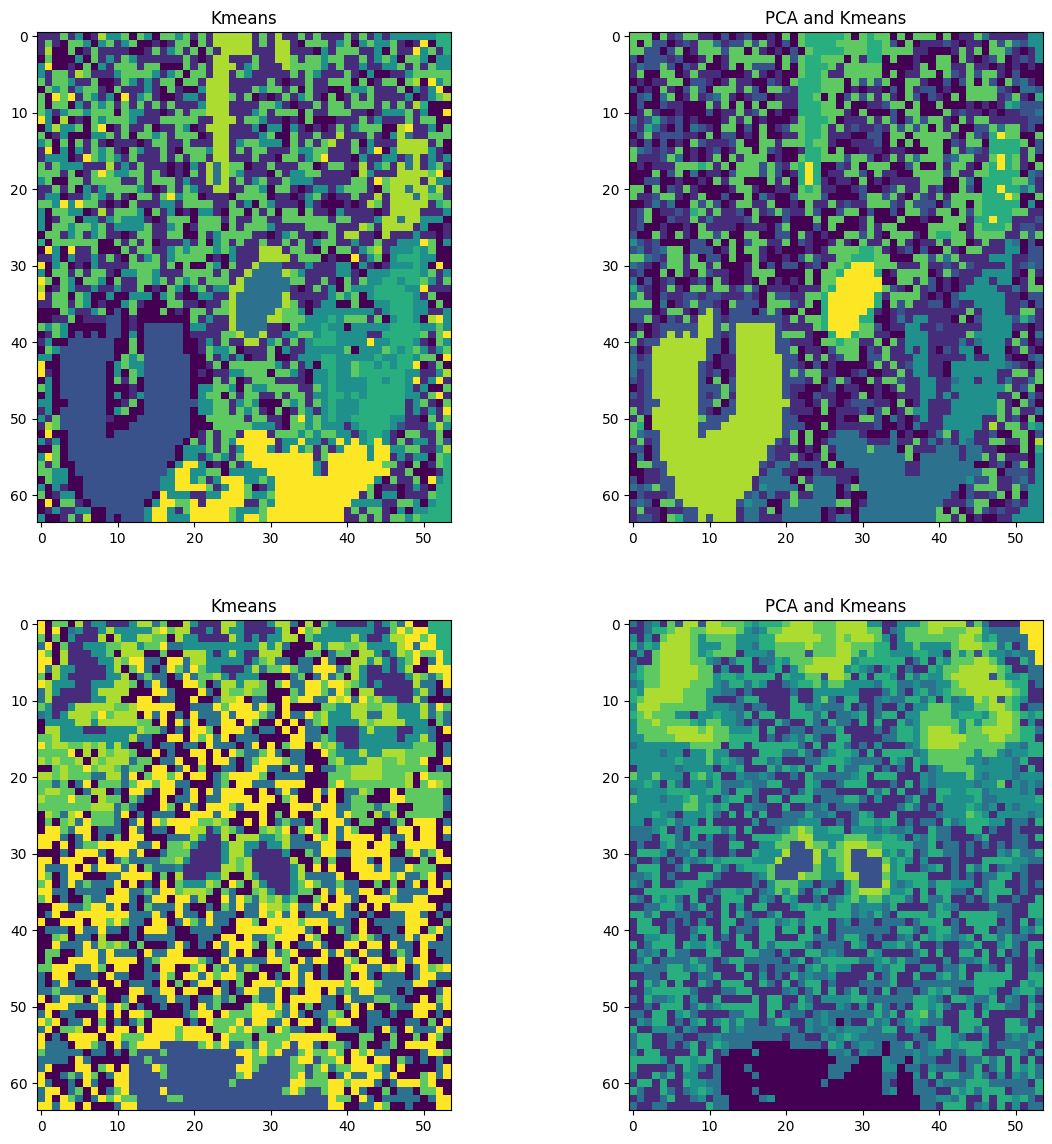

In [18]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(14, 14))
# Tester sur les TACS
n_clusters = 9
kmean: KMeans = KMeans(n_clusters=n_clusters)
pca: PCA = PCA(n_clusters)
labels = kmean.fit_predict(data_S)
ImSagittaleSC = np.reshape(labels, ((54, 64)))
axs[0][0].imshow(ImSagittaleSC.T)
axs[0][0].set_title('Kmeans')

data = pca.fit_transform(data_S)
labels = kmean.fit_predict(data)
ImSagittaleSC = np.reshape(labels, ((54, 64)))
axs[0][1].imshow(ImSagittaleSC.T)
axs[0][1].set_title('PCA and Kmeans')

# Tester sur les TACS
n_clusters = 5
labels = kmean.fit_predict(data_T)
ImSagittaleSC = np.reshape(labels, ((54, 64)))
axs[1][0].imshow(ImSagittaleSC.T)
axs[1][0].set_title('Kmeans')

data = pca.fit_transform(data_T)
labels = kmean.fit_predict(data)
ImSagittaleSC = np.reshape(labels, ((54, 64)))
axs[1][1].imshow(ImSagittaleSC.T)
axs[1][1].set_title('PCA and Kmeans')


# Partie IV : Comparaison avec vérité terrain

En utilisant la vérité terrain des coupes (repectivement les matrices _ImageROI_DataSagittale_, _Image_ROI_DataTransverse_, analyser vos résultats et améliorer les.

<img src="files/VeriteTerrain.png" width="600" height="300">


Text(0.5, 1.0, 'Partition kmeans')

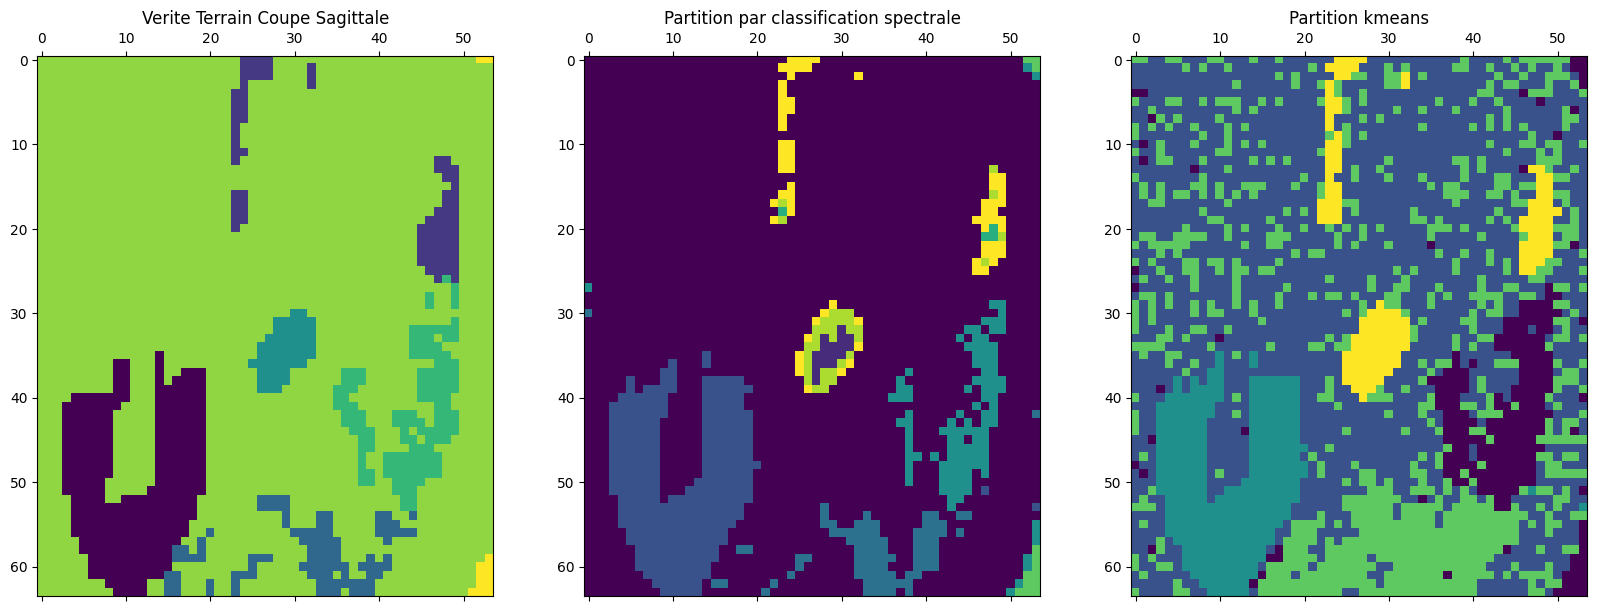

In [19]:
dataROISagit= scipy.io.loadmat('ImageROI_DataSagittale.mat') 
dataROI_S = pd.DataFrame(dataROISagit['Image_ROI_S'])

n_clusters = 5
kmean: KMeans = KMeans(n_clusters=n_clusters)

# résultat vérité terrain et clustering spectral
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 10))
axs[0].matshow(dataROI_S)
axs[0].set_title('Verite Terrain Coupe Sagittale')

PartitionSC_S = classification_spectrale(data_S, 9, 0.35)
ImSagittaleSC = np.reshape(PartitionSC_S, ((54, 64)))
axs[1].matshow(ImSagittaleSC.T)
axs[1].set_title('Partition par classification spectrale')

labels = kmean.fit_predict(data_S)
ImSagittaleSC = np.reshape(labels, ((54, 64)))
axs[2].matshow(ImSagittaleSC.T) # à modifier par Image issue du Kmeans
axs[2].set_title('Partition kmeans')


Text(0.5, 1.0, 'Partition kmeans')

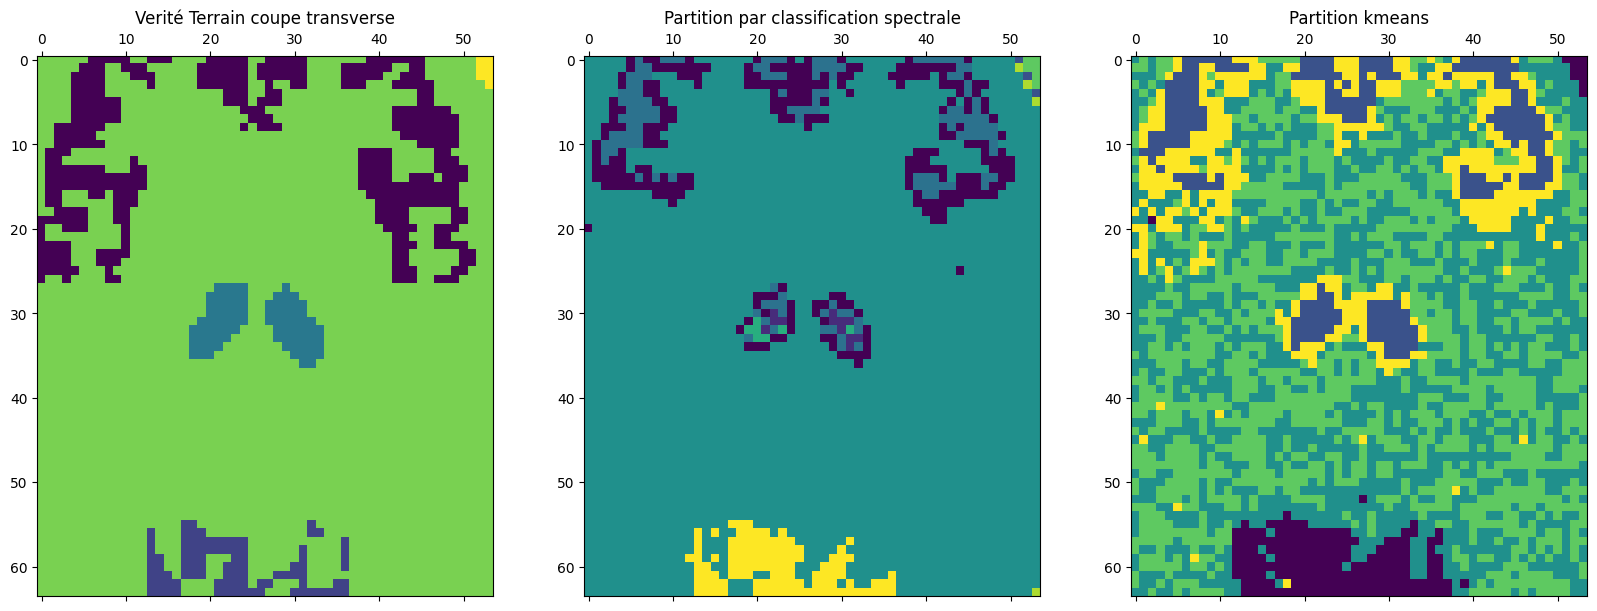

In [20]:
dataROITrans= scipy.io.loadmat('ImageROI_DataTransverse.mat')
dataROI_T = pd.DataFrame(dataROITrans['Image_ROI_T'])

n_clusters = 5
kmean: KMeans = KMeans(n_clusters=n_clusters)

# résultat vérité terrain et clustering spectral
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 10))
axs[0].matshow(dataROI_T)
axs[0].set_title('Verité Terrain coupe transverse')

PartitionSC_S = classification_spectrale(data_T, 9, 0.35)
ImTransverseSC = np.reshape(PartitionSC_S, ((54, 64)))
axs[1].matshow(ImTransverseSC.T)
axs[1].set_title('Partition par classification spectrale')

labels = kmean.fit_predict(data_T)
ImTransverseSC = np.reshape(labels, ((54, 64)))
axs[2].matshow(ImTransverseSC.T) # à modifier par Image issue du Kmeans
axs[2].set_title('Partition kmeans')

## Calcul de mesures de précision et rappel

**Précision :** évalue l'exactitude des prédictions positives
$$Precision=\frac{TP}{TP+FP}$$
**Rappel :** évalue le taux d'observations positives ayant été correctement détectées par le classifieur
$$Rappel = \frac{TP}{TP+FN}$$

<img src="files/PrecisionRappel.png" width="300" height="300">

**Indice de Fowlkes-Mallows index (FMI)** mesure la similarité entre deux partitionnements. C'est une moyenne géométrique entre la précision et le rappel :

$$FMI = \frac{TP}{\sqrt{TP + FP) * (TP + FN)}}$$


In [30]:
from sklearn.metrics.cluster import fowlkes_mallows_score

# Coupe Sagittale : Vectorisation de l'image de verité terrain
VecdataROI_S=np.ravel(dataROI_S)

n_clusters: int = 9
kmean: KMeans = KMeans(n_clusters=n_clusters)

# Mesure d'évalution pour la coupe sagittale  pour la classification spectrale
PartitionSC_S = classification_spectrale(data_S, n_clusters, 0.35)
resultatSC = fowlkes_mallows_score(VecdataROI_S,PartitionSC_S)
print('Resultat Sagittale - Classification Spectrale :',resultatSC)

# Mesure d'évalution pour la coupe sagittale  pour le Kmeans
PartitionSC_S = kmean.fit_predict(data_S)
resultatSC = fowlkes_mallows_score(VecdataROI_S, PartitionSC_S)
print('Resultat Sagittale - KMeans :', resultatSC)


Resultat Sagittale - Classification Spectrale : 0.6630122956758336
Resultat Sagittale - KMeans : 0.3517858152599653


In [31]:
# Coupe Transverse : Vectorisation de l'image de verité terrain
VecdataROI_T=np.ravel(dataROI_T)

n_clusters = 5
kmean: KMeans = KMeans(n_clusters=n_clusters)

# Mesure d'évalution pour la coupe transverse  pour la classification spectrale
PartitionSC_T = classification_spectrale(data_T, n_clusters, 0.35)
resultatSC = fowlkes_mallows_score(VecdataROI_T, PartitionSC_T)
print('Resultat Transverse - Classification Spectrale :',resultatSC)

# Mesure d'évalution pour la coupe transverse  pour le Kmeans
PartitionSC_T = kmean.fit_predict(data_T)
resultatSC = fowlkes_mallows_score(VecdataROI_T, PartitionSC_T)
print('Resultat Transverse - KMeans :',resultatSC)

Resultat Transverse - Classification Spectrale : 0.7380338582179793
Resultat Transverse - KMeans : 0.4614430754971213


# Partie V : votre analyse

A partir des méthodes que vous avez implémentées, sur le notebook

- Réaliser une analyse sur les résultats des méthodes de classification non supervisée : classification spectrale, kmeans et ACP+kmeans
- Tester pour différentes valeurs de paramètres $\sigma$ et de classes

Rédiger sur un cartouche l'analyse effectuée et vos conclusions.

Le notebook sera à rendre sur moodle.


## Votre analyse

Rédiger votre analyse et vos conclusions.


Sur des jeux de données comme celui ci-dessus, KMeans est très rapide en termes d'exécution mais n'est pas approprié pour les TAC car il fonctionne sur des données linéairement séparables, ce qui n'est pas nécessairement le cas sur ces données.
Ensuite, l'utilisation de l'ACP peut aider en réduisant le bruit de fond, ce qui peut conduire à une classification plus stable mais cela ne suffit pas pour avoir une valeur de similarité élevée.

Pour le jeu de données TACs, le plus approprié est la classification spectrale qui obtient sans contexte le score de similarité le plus élevé, avec pour côté négatif un temps d'exécution très long.
Dans la classification spectrale nous avons le choix des paramètres comme "sigma" qui permet de contrôler le lissage des données du groupe, donc nous devons choisir correctement selon les données une valeur de sigma aussi basse que possible sans avoir pour autant de perte de données.

Vous trouverez ci-dessous des exemples des différents scores de similarité en fonction du sigma et par jeu de données.

Pour conclure je dirais que pour des données comme les TACs, il est nécessaire d'utiliser la classification spectrale afin d'avoir de meilleurs résultats avec comme paramétres un sigma entre 0.45 et 0.6, et tous cela malgré sont long temps d'exécution.

Resultat Sagittale - KMeans : 0.3220425952187127
Resultat Sagittale - Classification Spectrale avec sigma = 0.15  : 0.695201111752752
Resultat Sagittale - Classification Spectrale avec sigma = 0.3  : 0.660591954233502
Resultat Sagittale - Classification Spectrale avec sigma = 0.44999999999999996  : 0.6683084772631387
Resultat Sagittale - Classification Spectrale avec sigma = 0.6  : 0.6686573956098136
Resultat Sagittale - Classification Spectrale avec sigma = 0.75  : 0.6720363801340985
Resultat Sagittale - Classification Spectrale avec sigma = 0.9  : 0.6298007884844153


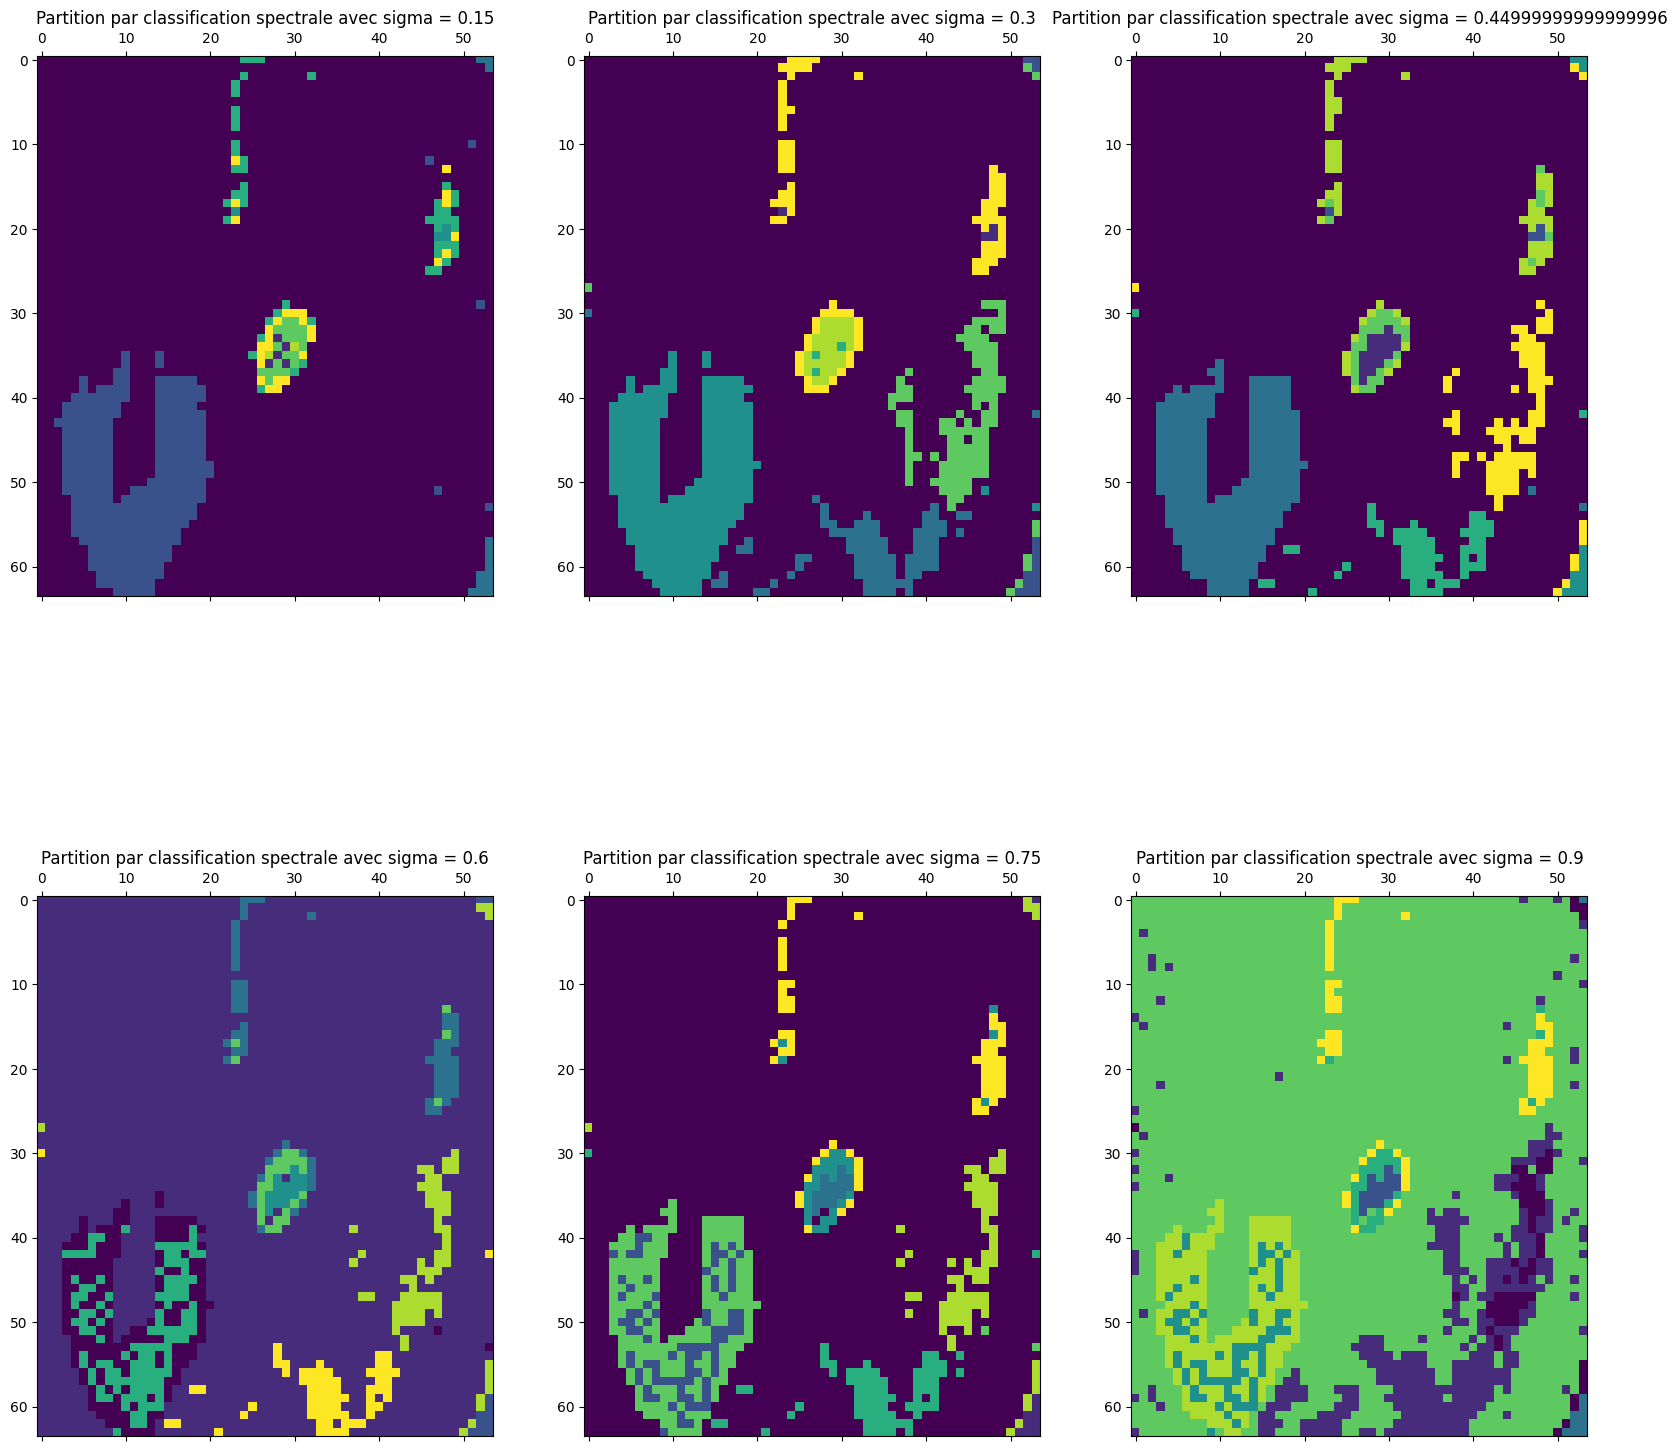

In [34]:
from sklearn.metrics.cluster import fowlkes_mallows_score

# Coupe Sagittale : Vectorisation de l'image de verité terrain
VecdataROI_S = np.ravel(dataROI_S)

n_clusters: int = 9
kmean: KMeans = KMeans(n_clusters=n_clusters)

# Mesure d'évalution pour la coupe sagittale  pour le Kmeans
PartitionSC_S = kmean.fit_predict(data_S)
resultatSC = fowlkes_mallows_score(VecdataROI_S, PartitionSC_S)
print('Resultat Sagittale - KMeans :', resultatSC)

sigma: float = 0
nb_test = 6
nb__each_row = 3
row = math.ceil(nb_test/nb__each_row)
fig, axs = plt.subplots(nrows=row,
                        ncols=nb__each_row, figsize=(20, 10 * row))
row = 0
for i in range(6):
    if i % nb__each_row == 0 and i != 0:
        row += 1
    sigma += 0.15
    # Mesure d'évalution pour la coupe sagittale  pour la classification spectrale
    PartitionSC_S = classification_spectrale(data_S, n_clusters, sigma)
    resultatSC = fowlkes_mallows_score(VecdataROI_S, PartitionSC_S)
    print('Resultat Sagittale - Classification Spectrale avec sigma = ' +
          str(sigma) + '  :', resultatSC)
    ImSagittaleSC = np.reshape(PartitionSC_S, ((54, 64)))
    axs[row][i % nb__each_row].matshow(ImSagittaleSC.T)
    axs[row][i % nb__each_row].set_title('Partition par classification spectrale avec sigma = ' +
                        str(sigma))

Resultat Transverse - KMeans : 0.46163236370283683
Resultat Transverse - Classification Spectrale avec sigma = 0.15  : 0.7665261759139249
Resultat Transverse - Classification Spectrale avec sigma = 0.3  : 0.7604844475831554
Resultat Transverse - Classification Spectrale avec sigma = 0.44999999999999996  : 0.7631650653365921
Resultat Transverse - Classification Spectrale avec sigma = 0.6  : 0.7545483958693517
Resultat Transverse - Classification Spectrale avec sigma = 0.75  : 0.7510994162961154
Resultat Transverse - Classification Spectrale avec sigma = 0.9  : 0.7451888949368057


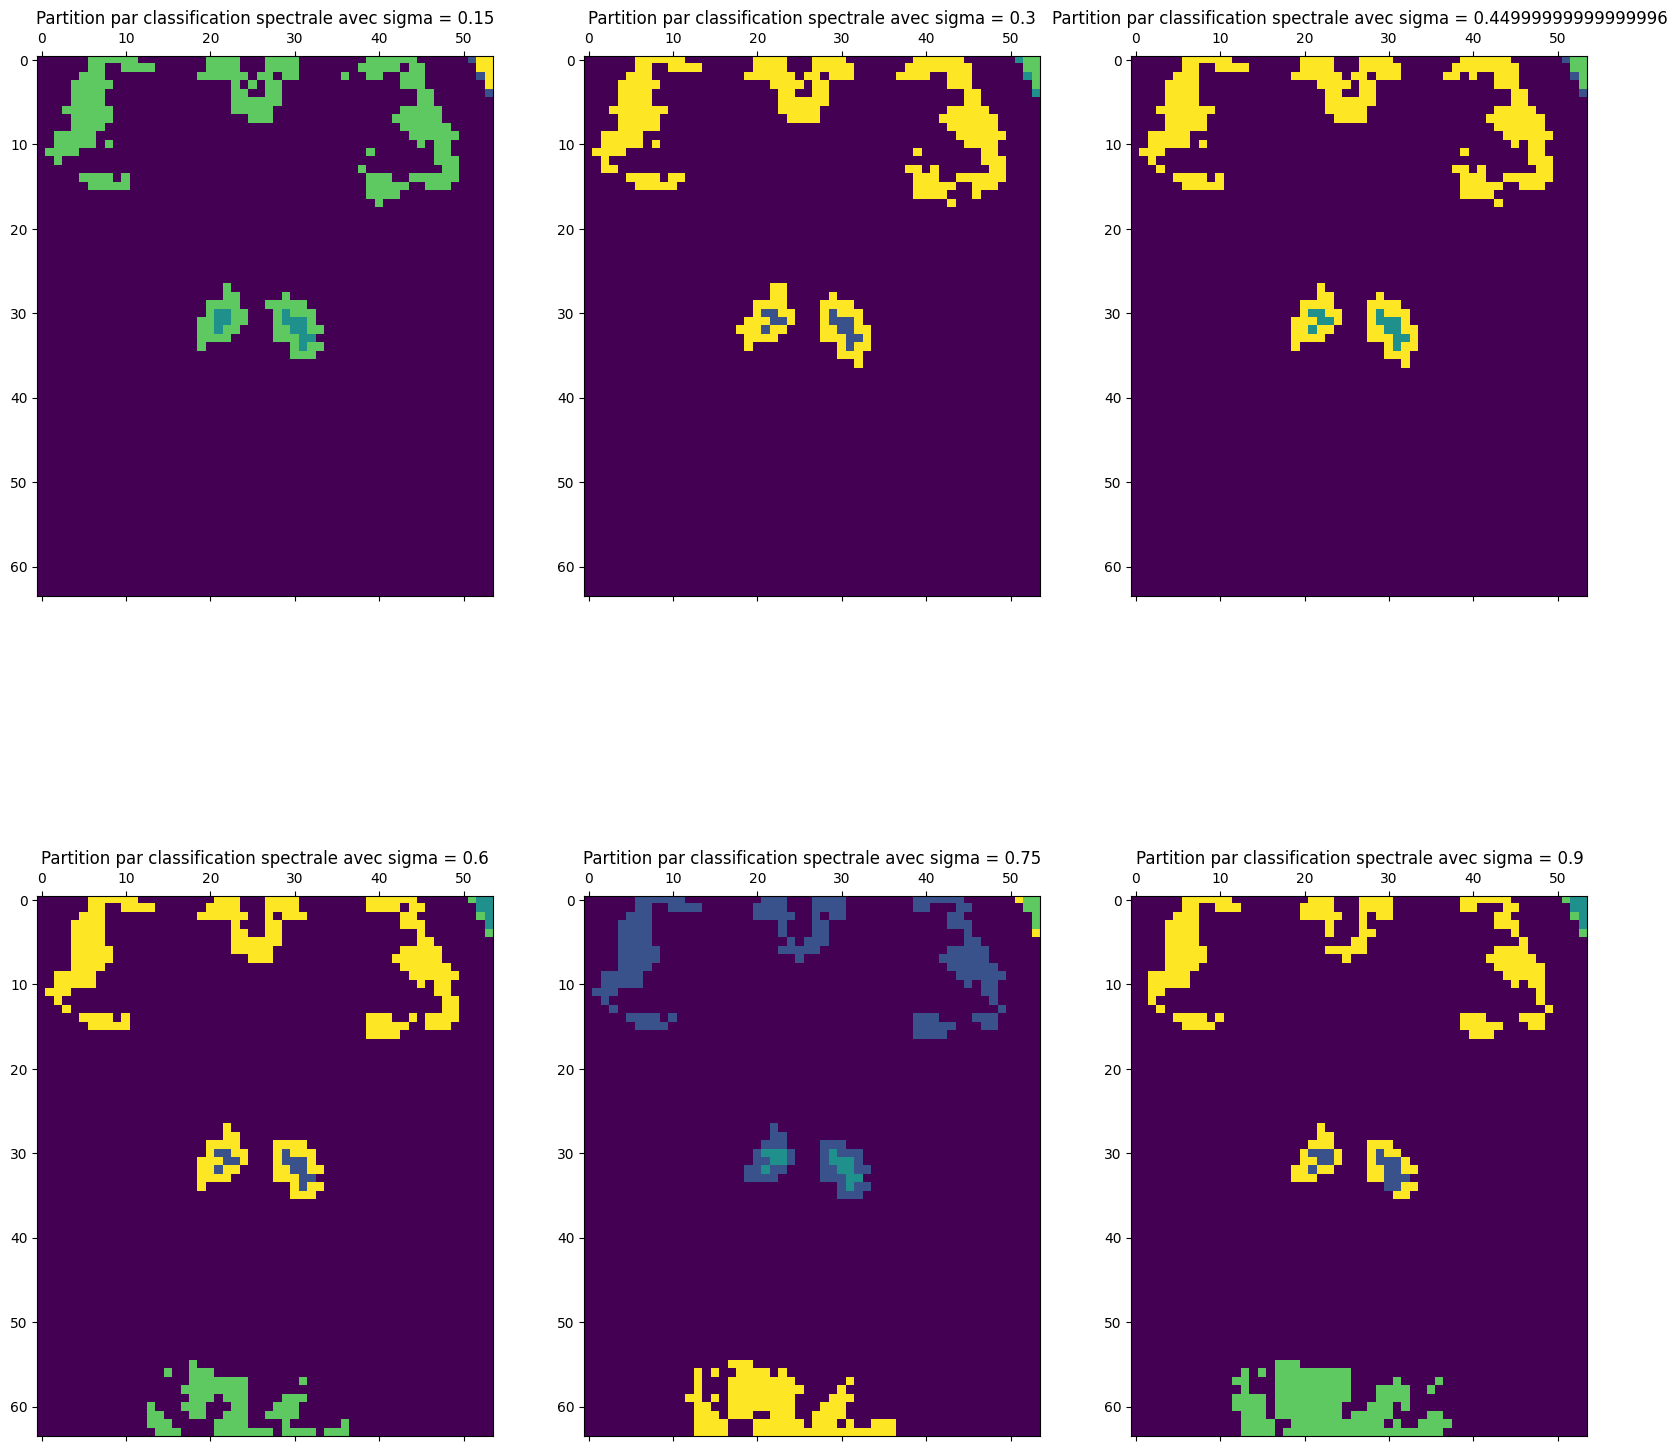

In [36]:
from sklearn.metrics.cluster import fowlkes_mallows_score

# Coupe Sagittale : Vectorisation de l'image de verité terrain
VecdataROI_T = np.ravel(dataROI_T)

n_clusters: int = 5
kmean: KMeans = KMeans(n_clusters=n_clusters)

# Mesure d'évalution pour la coupe sagittale  pour le Kmeans
PartitionSC_T = kmean.fit_predict(data_T)
resultatSC = fowlkes_mallows_score(VecdataROI_T, PartitionSC_T)
print('Resultat Transverse - KMeans :', resultatSC)

sigma: float = 0
nb_test = 6
nb__each_row = 3
row = math.ceil(nb_test/nb__each_row)
fig, axs = plt.subplots(nrows=row,
                        ncols=nb__each_row, figsize=(20, 10 * row))
row = 0
for i in range(6):
    if i % nb__each_row == 0 and i != 0:
        row += 1
    sigma += 0.15
    # Mesure d'évalution pour la coupe sagittale  pour la classification spectrale
    PartitionSC_T = classification_spectrale(data_T, n_clusters, sigma)
    resultatSC = fowlkes_mallows_score(VecdataROI_T, PartitionSC_T)
    print('Resultat Transverse - Classification Spectrale avec sigma = ' +
          str(sigma) + '  :', resultatSC)
    ImTransverseSC = np.reshape(PartitionSC_T, ((54, 64)))
    axs[row][i % nb__each_row].matshow(ImTransverseSC.T)
    axs[row][i % nb__each_row].set_title('Partition par classification spectrale avec sigma = ' +
                                         str(sigma))

*Document écrit et réaliser par Florent CADET.*